<a href="https://colab.research.google.com/github/Bhavika-30/Parallel-Distributed-Assignment/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem1

In [ ]:
%%writefile sum_cuda.cu
#include <stdio.h>
#include <cuda_runtime.h>

#define N 1024

__global__ void computeSums(int *input, int *output) {
    int tid = threadIdx.x;

    if (tid == 0) {
        int sum = 0;
        for (int i = 0; i < N; i++) {
            sum += input[i];
        }
        output[0] = sum;
    } else if (tid == 1) {
        int n = N;
        output[1] = n * (n + 1) / 2;
    }
}

int main() {
    int h_input[N], h_output[2] = {0, 0};
    int *d_input, *d_output;

    // Fill input array from 1 to N
    for (int i = 0; i < N; i++) {
        h_input[i] = i + 1;
    }

    cudaMalloc(&d_input, N * sizeof(int));
    cudaMalloc(&d_output, 2 * sizeof(int));

    cudaMemcpy(d_input, h_input, N * sizeof(int), cudaMemcpyHostToDevice);

    computeSums<<<1, 2>>>(d_input, d_output);
    cudaDeviceSynchronize();

    cudaMemcpy(h_output, d_output, 2 * sizeof(int), cudaMemcpyDeviceToHost);

    printf("Sum using iterative approach (Thread 0): %d\n", h_output[0]);
    printf("Sum using formula (Thread 1):           %d\n", h_output[1]);

    cudaFree(d_input);
    cudaFree(d_output);

    return 0;
}

Writing sum_cuda.cu


In [ ]:
!nvcc sum_cuda.cu -o sum_cuda
!./sum_cuda

Sum using iterative approach (Thread 0): 0
Sum using formula (Thread 1):           0


## Problem2

In [ ]:
%%writefile mergesort_compare.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>
#include <cuda.h>

#define N 1000

void merge(int* arr, int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;

    int *L = (int*)malloc(n1 * sizeof(int));
    int *R = (int*)malloc(n2 * sizeof(int));

    for (i = 0; i < n1; i++) L[i] = arr[l + i];
    for (j = 0; j < n2; j++) R[j] = arr[m + 1 + j];

    i = 0; j = 0; k = l;
    while (i < n1 && j < n2) arr[k++] = (L[i] <= R[j]) ? L[i++] : R[j++];
    while (i < n1) arr[k++] = L[i++];
    while (j < n2) arr[k++] = R[j++];

    free(L);
    free(R);
}

void mergeSortPipeline(int* arr, int l, int r) {
    if (l < r) {
        int m = (l + r) / 2;
        #pragma omp parallel sections
        {
            #pragma omp section
            mergeSortPipeline(arr, l, m);
            #pragma omp section
            mergeSortPipeline(arr, m + 1, r);
        }
        merge(arr, l, m, r);
    }
}

__device__ void mergeCuda(int* arr, int* temp, int l, int m, int r) {
    int i = l, j = m + 1, k = l;
    while (i <= m && j <= r) temp[k++] = (arr[i] <= arr[j]) ? arr[i++] : arr[j++];
    while (i <= m) temp[k++] = arr[i++];
    while (j <= r) temp[k++] = arr[j++];
    for (int x = l; x <= r; x++) arr[x] = temp[x];
}

__global__ void mergeSortCuda(int* arr, int* temp, int width, int n) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int l = tid * (2 * width);
    int m = l + width - 1;
    int r = l + 2 * width - 1;
    if (r >= n) r = n - 1;
    if (m < r)
        mergeCuda(arr, temp, l, m, r);
}

void parallelMergeSortCuda(int* arr, int n) {
    int *d_arr, *d_temp;
    cudaMalloc(&d_arr, n * sizeof(int));
    cudaMalloc(&d_temp, n * sizeof(int));
    cudaMemcpy(d_arr, arr, n * sizeof(int), cudaMemcpyHostToDevice);

    for (int width = 1; width < n; width *= 2) {
        int numThreads = (n + (2 * width) - 1) / (2 * width);
        mergeSortCuda<<<(numThreads + 255) / 256, 256>>>(d_arr, d_temp, width, n);
        cudaDeviceSynchronize();
    }

    cudaMemcpy(arr, d_arr, n * sizeof(int), cudaMemcpyDeviceToHost);
    cudaFree(d_arr);
    cudaFree(d_temp);
}

void printArray(int* arr, int n) {
    for (int i = 0; i < n; i++) {
        printf("%d ", arr[i]);
        if ((i + 1) % 20 == 0) printf("\n");
    }
    printf("\n");
}

int main() {
    int* arr = (int*)malloc(N * sizeof(int));
    int* arr_copy = (int*)malloc(N * sizeof(int));
    srand(time(NULL));
    for (int i = 0; i < N; i++) {
        arr[i] = rand() % 10000;
        arr_copy[i] = arr[i];
    }

    printf("Unsorted Array:\n");
    printArray(arr, N);

    double start = omp_get_wtime();
    mergeSortPipeline(arr, 0, N - 1);
    double end = omp_get_wtime();
    printf("\nSorted Array using Pipelined Merge Sort:\n");
    printArray(arr, N);
    printf("\nPipelined Merge Sort Time: %.6f seconds\n", end - start);

    start = omp_get_wtime();
    parallelMergeSortCuda(arr_copy, N);
    end = omp_get_wtime();
    printf("\nSorted Array using CUDA Merge Sort:\n");
    printArray(arr_copy, N);
    printf("\nCUDA Merge Sort Time: %.6f seconds\n", end - start);

    free(arr);
    free(arr_copy);
    return 0;
}

Overwriting mergesort_compare.cu


In [ ]:
!nvcc mergesort_compare.cu -o mergesort_compare -Xcompiler -fopenmp

In [ ]:
!./mergesort_compare

Unsorted Array:
4130 6744 6748 6474 1618 7795 568 7041 8691 9243 7282 8545 1645 3270 7726 2673 6440 3377 3289 7419 
1053 2275 1279 8331 7215 3718 7838 513 8778 8509 8117 2908 1606 4865 5734 3224 2661 6302 6617 7704 
5545 251 6249 3542 9873 327 6215 6313 57 5856 84 1110 8132 1364 5793 1699 5082 3631 8565 213 
8493 6682 9473 99 1548 5208 9675 561 7862 6293 8265 3408 2896 867 6950 2770 7546 9518 5435 7603 
5374 5520 8713 9858 6884 859 7910 8318 4490 6475 4883 2983 3157 4357 9434 1057 9565 5462 1618 7427 
8107 6236 7187 1003 7103 490 3773 4649 8 5561 8605 1734 1081 7318 1593 4317 4529 9503 8987 9020 
5978 3871 8355 5487 8228 7790 6545 4145 9604 8163 1572 7711 4399 5112 8714 7854 5602 8840 2504 1962 
4401 1109 3696 1834 4779 5289 6151 9309 1144 1490 4681 7122 5361 3036 8962 3589 7178 5507 7734 6782 
22 5659 845 4422 771 9560 2276 2725 4752 1132 4687 5505 8593 4735 7339 9725 25 9842 5386 7521 
1332 67 4644 3046 9455 9958 6635 2986 5465 722 6120 5487 2733 6966 6261 9856 2878 4890 2581 7630 
6

In [ ]:
%%writefile mergesort_compare.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>
#include <cuda.h>

int N;

void merge(int* arr, int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;

    int *L = (int*)malloc(n1 * sizeof(int));
    int *R = (int*)malloc(n2 * sizeof(int));

    for (i = 0; i < n1; i++) L[i] = arr[l + i];
    for (j = 0; j < n2; j++) R[j] = arr[m + 1 + j];

    i = 0; j = 0; k = l;
    while (i < n1 && j < n2) arr[k++] = (L[i] <= R[j]) ? L[i++] : R[j++];
    while (i < n1) arr[k++] = L[i++];
    while (j < n2) arr[k++] = R[j++];

    free(L);
    free(R);
}

void mergeSortPipeline(int* arr, int l, int r) {
    if (l < r) {
        int m = (l + r) / 2;
        #pragma omp parallel sections
        {
            #pragma omp section
            mergeSortPipeline(arr, l, m);
            #pragma omp section
            mergeSortPipeline(arr, m + 1, r);
        }
        merge(arr, l, m, r);
    }
}

__device__ void mergeCuda(int* arr, int* temp, int l, int m, int r) {
    int i = l, j = m + 1, k = l;
    while (i <= m && j <= r) temp[k++] = (arr[i] <= arr[j]) ? arr[i++] : arr[j++];
    while (i <= m) temp[k++] = arr[i++];
    while (j <= r) temp[k++] = arr[j++];
    for (int x = l; x <= r; x++) arr[x] = temp[x];
}

__global__ void mergeSortCuda(int* arr, int* temp, int width, int n) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int l = tid * (2 * width);
    int m = l + width - 1;
    int r = l + 2 * width - 1;
    if (r >= n) r = n - 1;
    if (m < r)
        mergeCuda(arr, temp, l, m, r);
}

void parallelMergeSortCuda(int* arr, int n) {
    int *d_arr, *d_temp;
    cudaMalloc(&d_arr, n * sizeof(int));
    cudaMalloc(&d_temp, n * sizeof(int));
    cudaMemcpy(d_arr, arr, n * sizeof(int), cudaMemcpyHostToDevice);

    for (int width = 1; width < n; width *= 2) {
        int numThreads = (n + (2 * width) - 1) / (2 * width);
        mergeSortCuda<<<(numThreads + 255) / 256, 256>>>(d_arr, d_temp, width, n);
        cudaDeviceSynchronize();
    }

    cudaMemcpy(arr, d_arr, n * sizeof(int), cudaMemcpyDeviceToHost);
    cudaFree(d_arr);
    cudaFree(d_temp);
}

void printArray(int* arr, int n) {
    for (int i = 0; i < n; i++) {
        printf("%d ", arr[i]);
        if ((i + 1) % 20 == 0) printf("\n");
    }
    printf("\n");
}

int main(int argc, char** argv) {
    if (argc != 2) {
    printf("Usage: %s <array_size>\n", argv[0]);
    return 1;
    }
    N = atoi(argv[1]);

    int* arr = (int*)malloc(N * sizeof(int));
    int* arr_copy = (int*)malloc(N * sizeof(int));
    srand(time(NULL));
    for (int i = 0; i < N; i++) {
        arr[i] = rand() % 10000;
        arr_copy[i] = arr[i];
    }

    printf("Unsorted Array:\n");
    printArray(arr, N);

    double start = omp_get_wtime();
    mergeSortPipeline(arr, 0, N - 1);
    double end = omp_get_wtime();
    printf("\nSorted Array using Pipelined Merge Sort:\n");
    printArray(arr, N);
    printf("\nPipelined Merge Sort Time: %.6f seconds\n", end - start);

    start = omp_get_wtime();
    parallelMergeSortCuda(arr_copy, N);
    end = omp_get_wtime();
    printf("\nSorted Array using CUDA Merge Sort:\n");
    printArray(arr_copy, N);
    printf("\nCUDA Merge Sort Time: %.6f seconds\n", end - start);

    free(arr);
    free(arr_copy);
    return 0;
}


Overwriting mergesort_compare.cu


In [ ]:
!nvcc mergesort_compare.cu -o mergesort_compare -Xcompiler -fopenmp
!./mergesort_compare 10000

Unsorted Array:
1370 682 8337 404 1942 885 1536 9911 8781 1609 7856 6618 5923 2935 6006 7219 728 4595 2258 5423 
310 3733 3555 2901 8397 3106 1532 5451 3879 1099 2926 1601 1781 1263 2005 76 8500 9893 9987 3634 
1502 4195 252 3777 3482 2610 997 4210 7205 3255 9634 3867 3340 9541 3121 8089 2647 4653 3540 6526 
5752 6466 4480 3886 4082 6485 3962 2582 6379 301 6216 4233 848 2820 8011 4331 5431 9008 8541 8988 
8615 8175 9208 1955 7716 2329 45 6715 6982 3585 9594 2734 6404 4074 6620 486 559 6934 9420 3290 
7235 5637 3876 4436 8457 1887 8767 240 895 7308 5581 5862 1836 4789 7817 9552 7118 4214 2620 452 
7800 2214 9538 556 2640 6159 1042 9551 9445 462 2842 3033 2451 6718 7469 7261 4957 6236 3853 2204 
9896 9434 8066 1732 4223 5883 7637 7693 6450 257 4497 4250 8823 4036 4806 1463 195 2200 1014 5992 
9014 208 9025 1466 3278 6494 5079 8235 9082 8932 6791 8979 8367 4857 7063 8942 7093 4700 2988 3543 
1309 7485 4145 132 1521 5303 7947 8068 7503 5314 413 2869 5522 9438 687 5153 2285 5766 9740 7719 


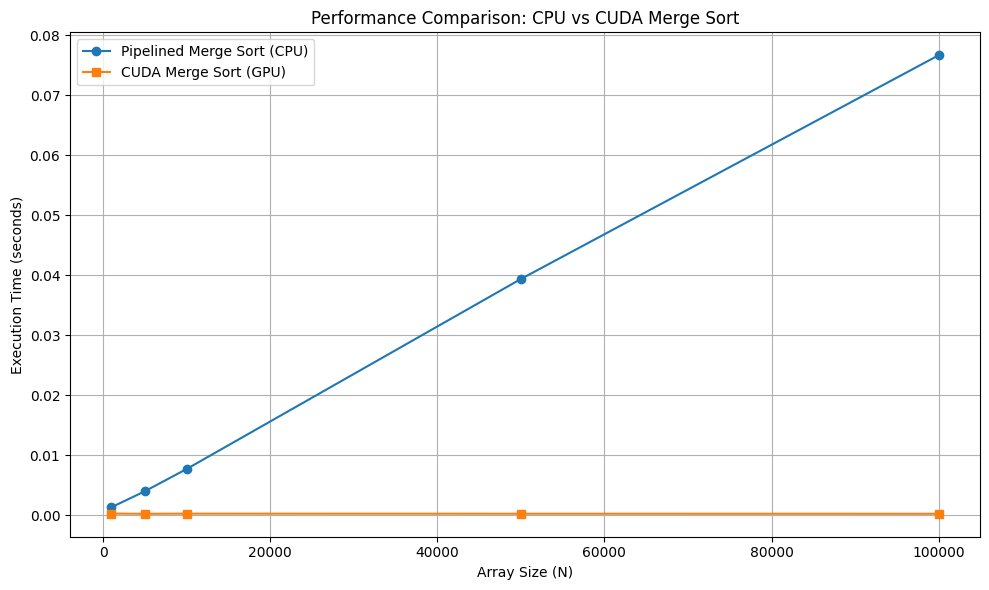

In [ ]:
import subprocess
import matplotlib.pyplot as plt

sizes = [1000, 5000, 10000, 50000, 100000]
cpu_times = []
gpu_times = []

# Compile the CUDA code
!nvcc -Xcompiler -fopenmp mergesort_compare.cu -o mergesort_compare

for size in sizes:
    result = subprocess.run(
        ['./mergesort_compare', str(size)],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    output = result.stdout

    # Extract timing data
    cpu_line = [line for line in output.splitlines() if "Pipelined Merge Sort Time" in line]
    gpu_line = [line for line in output.splitlines() if "CUDA Merge Sort Time" in line]

    cpu_time = float(cpu_line[0].split()[-2])
    gpu_time = float(gpu_line[0].split()[-2])

    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, cpu_times, label='Pipelined Merge Sort (CPU)', marker='o')
plt.plot(sizes, gpu_times, label='CUDA Merge Sort (GPU)', marker='s')
plt.xlabel('Array Size (N)')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance Comparison: CPU vs CUDA Merge Sort')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
